In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from pathlib import Path
from tqdm import tqdm

from common import Intrinsics

In [2]:
def generate_rays(pose, intr, size=1):
    x_coords = np.arange(intr.w, dtype=np.float32)
    y_coords = np.arange(intr.h, dtype=np.float32)
    w, h = intr.w, intr.h
    dx, dy = 0, 0
    pose_r, pose_t = pose[:3, :3], pose[:3, 3]

    i, j = np.meshgrid(x_coords, y_coords, indexing='xy')
    k = np.ones_like(i)

    # Pixel coords to camera frame
    dirs = np.stack([(i - intr.cx) / intr.fx, (j - intr.cy) / intr.fy, k], axis=-1)
    
    # Camera frame to world frame
    rays_d = np.einsum('ij, hwj -> hwi', pose_r, dirs)
    rays_d = rays_d / np.linalg.norm(rays_d, axis=2, keepdims=True) * size
    return rays_d

In [3]:
def load_llff(root_path):
    # Correct camera coords to canonical system
    # +X: right, +Y: bottom, +Z: front
    camera_t = np.array([[0, 0, -1], [0, -1, 0], [-1, 0, 0]])
    
    # Correct world coords to canonical system
    # +X: right, +Y: front, +Z: top
    pose_t = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
    
    poses_path = Path(root_path) / 'poses_bounds.npy'
    
    poses_arr = np.load(poses_path)
    poses, bounds = np.split(poses_arr, [15, ], axis=1)
    poses = poses.reshape(-1, 3, 5)
    h, w, f = poses[0, :, 4]
    intr = Intrinsics(h, w, f, f, w // 2, h // 2)
    
    # (N, 3, 5) -> (N, 4, 4)
    poses = np.concatenate([poses[:, :, :4], np.tile([0, 0, 0, 1], (len(poses), 1, 1))], axis=1)
    poses = np.einsum('ij, njk -> nik', pose_t, poses[:, :, :4])[:, :3]
    
    # (N, 3, 4) -> (N, 3, 3)
    poses[:, :, :3] = np.einsum('ij, njk -> nik', camera_t, poses[:, :, :3])
    return poses, intr

In [4]:
def load_nsvf(root_path):
    pose_dir = Path(root_path) / 'pose'
    intrinsics_path = Path(root_path) / 'intrinsics.txt'
    pose_paths = sorted(pose_dir.glob('0_*.txt'))
    
    poses = np.zeros((len(pose_paths), 3, 4))
    for i, path in enumerate(pose_paths):
        vals = [[float(w) for w in line.strip().split()] for line in open(path)]
        poses[i] = np.array(vals).astype(np.float32)[:3]
    
    with open(intrinsics_path, 'r') as file:
        f, cx, cy, _ = map(float, file.readline().split())
    intr = Intrinsics(800, 800, f, f, cx, cy)
    
    return poses, intr

In [5]:
def load_replica(root_path):
    pose_path = Path(root_path) / 'cameras.json'
    camera_t = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    pose_t = np.array([[0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
    
    with open(pose_path) as f:
        poses_list = json.load(f)
    
    poses = np.stack([p['Rt'] for p in poses_list], axis=0)
    for i in range(len(poses)):
        R, t = np.copy(poses[i, :3, :3]), np.copy(poses[i, :3, 3])
        poses[i, :3, 3] = -np.matmul(R.T, t)
        poses[i, :3, :3] = np.matmul(camera_t, R).T
    
    poses = np.einsum('ij, njk -> nik', pose_t, poses)[:, :3]
    intr = Intrinsics(512, 512, 800.0, 800.0, 256.0, 256.0)
    print(intr)
    
    return poses[:, :3], intr

In [6]:
# poses, intr = load_llff('/home/hwpang/datasets/nerf_llff_data/fern')
# poses, intr = load_llff('/home/hwpang/datasets/nerf_llff_data/room')
# poses, intr = load_nsvf('/home/hwpang/datasets/nsvf/Synthetic_NeRF/Chair')
poses, intr = load_replica('/home/hwpang/datasets/replica_all/train/00')

origins = poses[:, :, 3]
dests_lr = np.zeros((2, len(origins), 3))
dests_corner = np.zeros((4, len(origins), 3))

for i, pose in tqdm(enumerate(poses), total=len(poses)):
    dests = generate_rays(pose, intr, size=0.4)
    
    dests_lr[0, i] = dests[int(intr.w / 2), 0]
    dests_lr[1, i] = dests[int(intr.w / 2), -1]
    
    dests_corner[0, i] = dests[0, 0]
    dests_corner[1, i] = dests[0, -1]
    dests_corner[2, i] = dests[-1, 0]
    dests_corner[3, i] = dests[-1, -1]

Intrinsics(h=512, w=512, fx=800.0, fy=800.0, cx=256.0, cy=256.0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.28it/s]


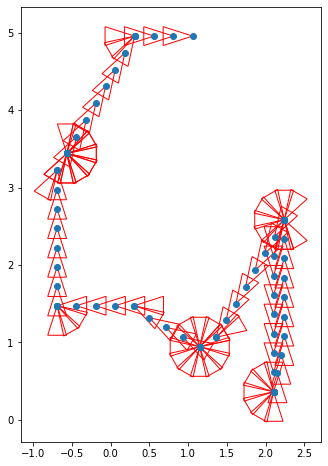

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 8))

for i in range(len(origins)):
    origin = origins[i]
    left, right = dests_lr[0, i], dests_lr[1, i]
    tri_coords = np.stack([origin, origin + left, origin + right], axis=0)[:, [0, 1]]
    ax.add_patch(plt.Polygon(tri_coords, edgecolor='red', fill=False))

ax.scatter(origins[:, 0], origins[:, 1])

ax.set_aspect('equal')
fig.show()

<IPython.core.display.Javascript object>


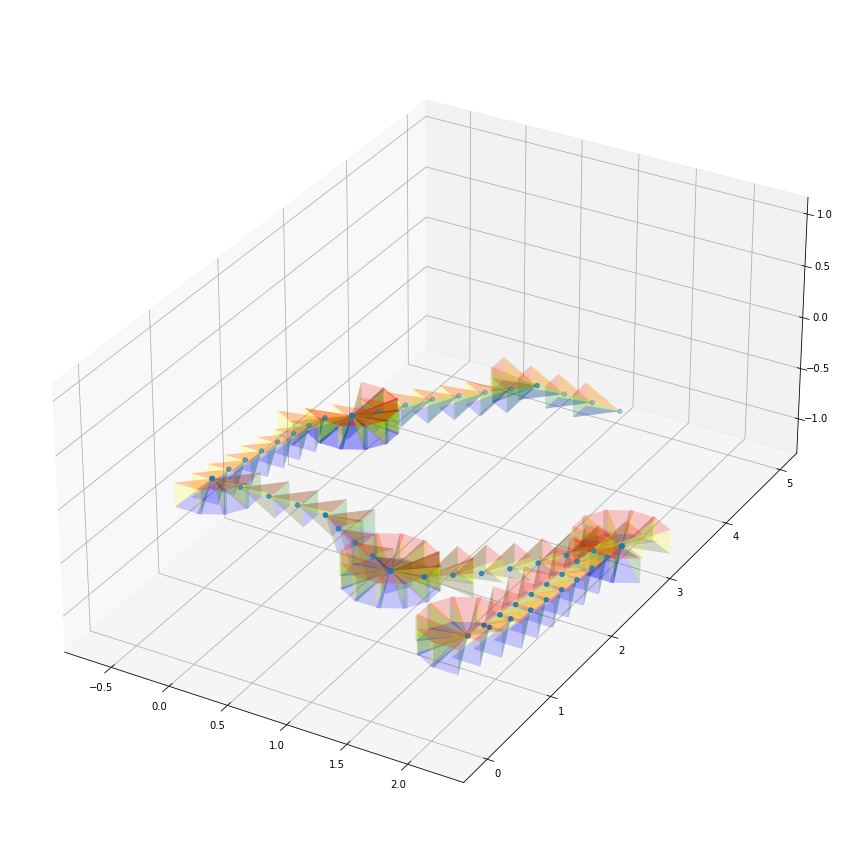

/home/hwpang/miniconda3/envs/nerf-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


2.932801604270935 4.592658668756485 0.6561441421508789


In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = a3.Axes3D(fig)
ax.set_box_aspect((np.ptp(origins[:, 0]), np.ptp(origins[:, 1]), np.ptp(origins[:, 2]*3)))

print(np.ptp(origins[:, 0]), np.ptp(origins[:, 1]), np.ptp(origins[:, 2]))

for i in range(len(origins)):
    c0 = origins[i]
    c1, c2, c3, c4 = [origins[i] + dests_corner[j, i] for j in range(4)]
    ax.add_collection3d(a3.art3d.Poly3DCollection([c0, c1, c2], facecolor='red', alpha=0.2))  # top
    ax.add_collection3d(a3.art3d.Poly3DCollection([c0, c1, c3], facecolor='green', alpha=0.2))  # left
    ax.add_collection3d(a3.art3d.Poly3DCollection([c0, c3, c4], facecolor='blue', alpha=0.2))  # bottom
    ax.add_collection3d(a3.art3d.Poly3DCollection([c0, c2, c4], facecolor='yellow', alpha=0.2))  # right

ax.scatter3D(origins[:, 0], origins[:, 1], origins[:, 2])

In [9]:
dests_corner[:, 0]

array([[-0.36442026, -0.11661448,  0.11661448],
       [-0.36454107,  0.11619746,  0.11665314],
       [-0.36454107, -0.11665314, -0.11619746],
       [-0.36466201,  0.11623601, -0.11623601]])